
# Description

This notebook explores the effect of "overfitting" data splitting on subsequent treatment effect estimates.

# Imports

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from linearmodels.iv import IV2SLS

# Common issue with glibc, scikit (?), where the number of libraries loaded with static TLS is limited
# Can only load one of econml or rpy2...
# e.g. https://github.com/pytorch/pytorch/issues/2575#issuecomment-523657178
from econml.dml import CausalForestDML

import sys

# user imports
sys.path.append("../")

# Don't import iv_power for now since it needs rpy2
from utils.pwr import rdd_power #, iv_power

## Matplotlib setup

In [6]:
# matplotlib config
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

## RPy2 setup

In [7]:
#Import necessary packages
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# #Must be activated
# pandas2ri.activate()

# Simulation data functions

In [8]:
def generate_IV_comply_indicator(n_samples, tau, seed=0, 
                                 prop_nt=0.4, prop_at=0.4, prop_z=0.5, 
                                 C_T=0.8, Z_T=0.8):
    """
    Generates IV data with perfect compliance indicator X.
    
    Note from Baocchi et al. 2014 Eq 16 that "instrument strength" is equivalent to proportion of compliers.
    
    
    See this for simulating IVs:
        - https://statmodeling.stat.columbia.edu/2019/06/20/how-to-simulate-an-instrumental-variables-problem/
    
    Args:
        n_samples (int): the number of samples to generate
        tau (float): the treatment effect on compliers to measure
        seed (int): see for reproducibility
        prop_nt (float): the proportion of never takers
        prop_at (float): the proportion of always takers, note that prop_comply is then 1 - prop_nt - prop_at
        prop_z (float): the proportion of individuals "encouraged" by the instrument
        C_T (float): the covariance between the confounder and treatment; only applies to compliers 
                     TODO is this an issue?
        Z_T (float): the covariance between the instrument and treatment
    """
    assert (prop_nt + prop_at) < 1, "proportion of compliers needs to be > 0"
    
    np.random.seed(seed)
    feat_df = pd.DataFrame()
    feat_df['comply_coeff'] = np.random.uniform(0, 1, size=n_samples)

    def comply_indicator(x):
        if x < prop_nt:
            return 'nt'
        elif x < prop_nt + prop_at:
            return 'at'
        else:
            return 'co'

    feat_df['comply_status'] = feat_df['comply_coeff'].apply(comply_indicator)
    X = (feat_df['comply_status'] == 'co').astype(int)
    
    # vars:             Z    T    C
    covar = np.array([[1.0, Z_T, 0.0], # Z
                      [Z_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    
    covar += np.eye(3,3)

    # vars:  Z  T  C
    means = [0, 0, 0]

    # generate Z, T, Z
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)
    
    # generate binary instrument
    Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)
    
    # generate endogenous treatment
    T = (data[:, 1] > 0).astype(int)

    # fill in Z when the sample is a complier, 0 for nt, 1 for at
    T = np.where(feat_df['comply_status'] == 'co', Z, T)
    T = np.where(feat_df['comply_status'] == 'nt', 0, T)
    T = np.where(feat_df['comply_status'] == 'at', 1, T)
    
    C = data[:, 2]
    
    # add noncomplier bias
    nc_bias_eff = 0.25
    B = np.where(X != 1, nc_bias_eff, 0)

    Y = (tau + B)*T + C + np.random.normal(0, 1, n_samples)
    
    feat_df['Z'] = Z
    feat_df['X'] = X
    feat_df['T'] = T
    feat_df['C'] = C
    feat_df['Y'] = Y
    feat_df['B'] = B
    
    return feat_df

In [9]:
formula = 'Y ~ 1 + [T ~ Z]'

def simulation(n, tau, prop_comply, n_trials, exclude_criteria=None, confound_str=0.8):
    pwrs = []
    tau_hats = []
    n_excluded = []
    var_hats = []
    
    for trial in range(n_trials):
        prop_nt = (1 - prop_comply) / 2
        prop_at = (1 - prop_comply) / 2
        #df = generate_IV(n, tau, prop_comply, trial, confound_str)
        df = generate_IV_comply_indicator(n, tau, 
                                          prop_nt=prop_nt, prop_at=prop_at, 
                                          seed=trial, C_T=confound_str)
        
        if exclude_criteria == "TneqZ":
            sel_df = df[df['T'] == df['Z']]
        elif exclude_criteria == "comply":
            sel_df = df[df['X'] == 1]
        elif exclude_criteria is None:
            sel_df = df
            
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')
        var = iv_results.std_errors['T']**2
        tau_hat = iv_results.params['T']
        
        pwr = rdd_power(tau, var)
        pwrs.append(pwr)
        tau_hats.append(tau_hat)
        var_hats.append(var)
        
        n_excluded.append(df.shape[0] - sel_df.shape[0])

    return tau_hats, pwrs, var_hats, n_excluded

In [10]:
def plot_results(tau, tau_hats, pwrs, var_hats, n_exclude):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), dpi=150)
    sns.boxplot(data=tau_hats, ax=ax1, orient='h')
    ax1.axvline(tau, color='black', ls='--', label="true treatment effect", )
    ax1.set_xlim(tau - 1.5, tau + 1.5)
    ax1.legend()
    ax1.set_ylabel("Est. treatment effect")

    sns.boxplot(data=pwrs, color='green', ax=ax2, orient='h')
    ax2.set_xlim(0, 1)
    ax2.set_ylabel("Est. power")
    
    
    sns.boxplot(data=var_hats, color='red', ax=ax3, orient='h')
    ax3.set_xlim(0, 0.5)
    ax3.set_ylabel("Std. errors")

    
    sns.boxplot(data=n_exclude, color='orange', ax=ax4, orient='h')
    #ax2.set_xlim(0, 1)
    ax4.set_ylabel("Num excluded")

## Single-run test

In [11]:
n_samples = 1000
prop_comply = 0.5
tau = 0.5
seed = 42

# by default, set prop_nt = prop_at
prop_nt = (1 - prop_comply) / 2
prop_at = (1 - prop_comply) / 2


iv_df = generate_IV_comply_indicator(n_samples, tau, seed=seed, prop_at=prop_at, prop_nt=prop_nt)

formula = 'Y ~ 1 + [T ~ Z]'
iv_model = IV2SLS.from_formula(formula, iv_df)
iv_results = iv_model.fit(cov_type='robust')

In [12]:
display(iv_results)
var = iv_results.std_errors['T']**2
print("rdd_power() calculation: {:.3f}".format(rdd_power(tau, var)))
#print("iv_power() calculation: {:.3f}".format(iv_power(iv_df, tau, robust_se=False)))

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0104
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0095
No. Observations:                1000   F-statistic:                    6.2363
Date:                Sat, Oct 02 2021   P-value (F-stat)                0.0125
Time:                        16:22:59   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.0221     0.1029    -0.2146     0.8301     -0.2238      0.1797
T              0.4945     0.1980     2.4973     0.0125      0.1064      0.8826
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f405b7f80d0

rdd_power() calculation: 0.714


## Simulation sandbox

In [34]:
n = 500
n_trials = 500
prop_comply = 0.5
tau = 0.5

0.6274959517518255
CPU times: user 1min 17s, sys: 2.49 s, total: 1min 20s
Wall time: 10 s


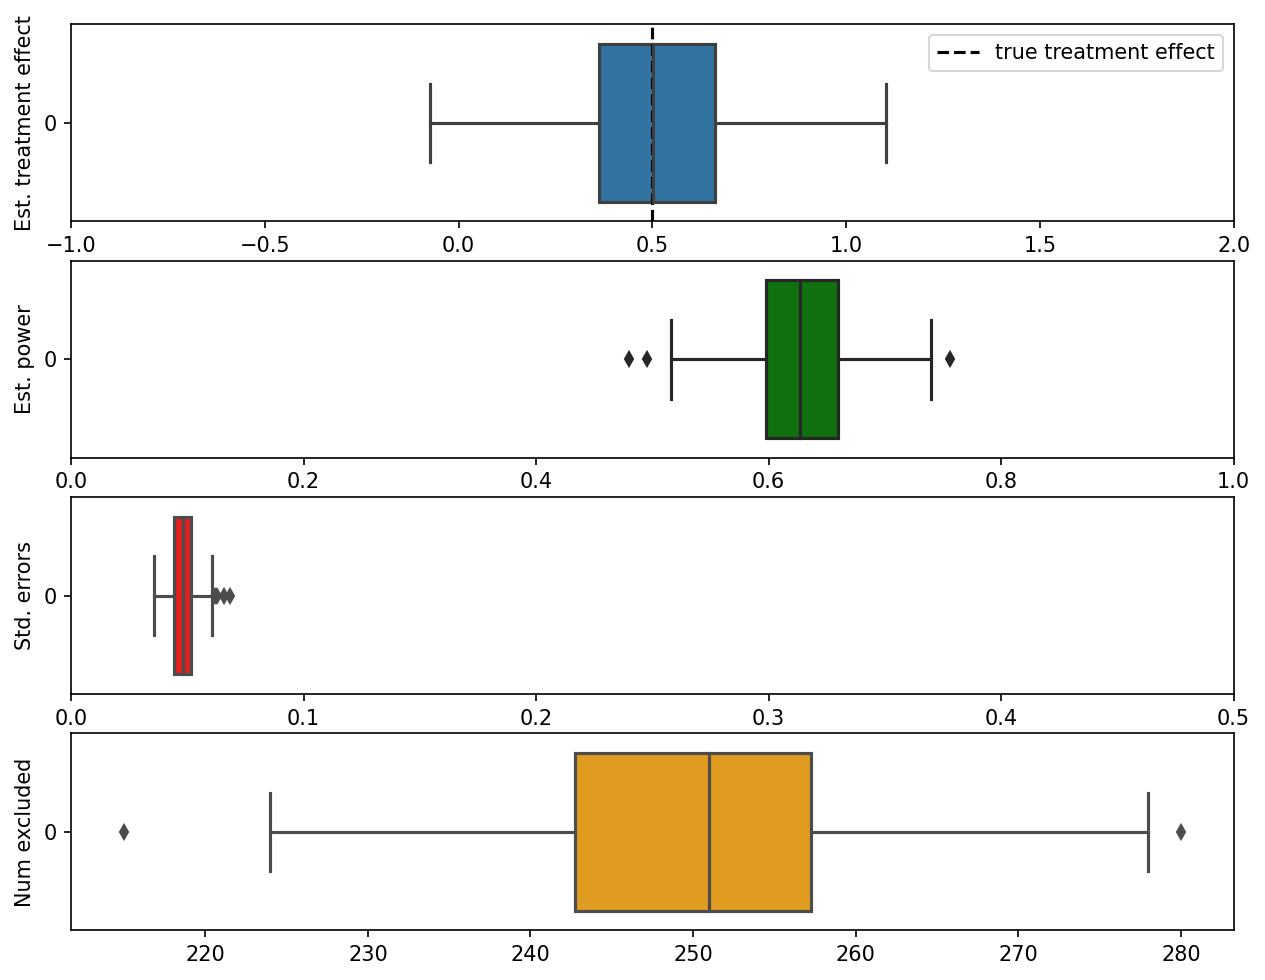

In [35]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "comply")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.7972675837705235
CPU times: user 1min 52s, sys: 3.47 s, total: 1min 56s
Wall time: 14.5 s


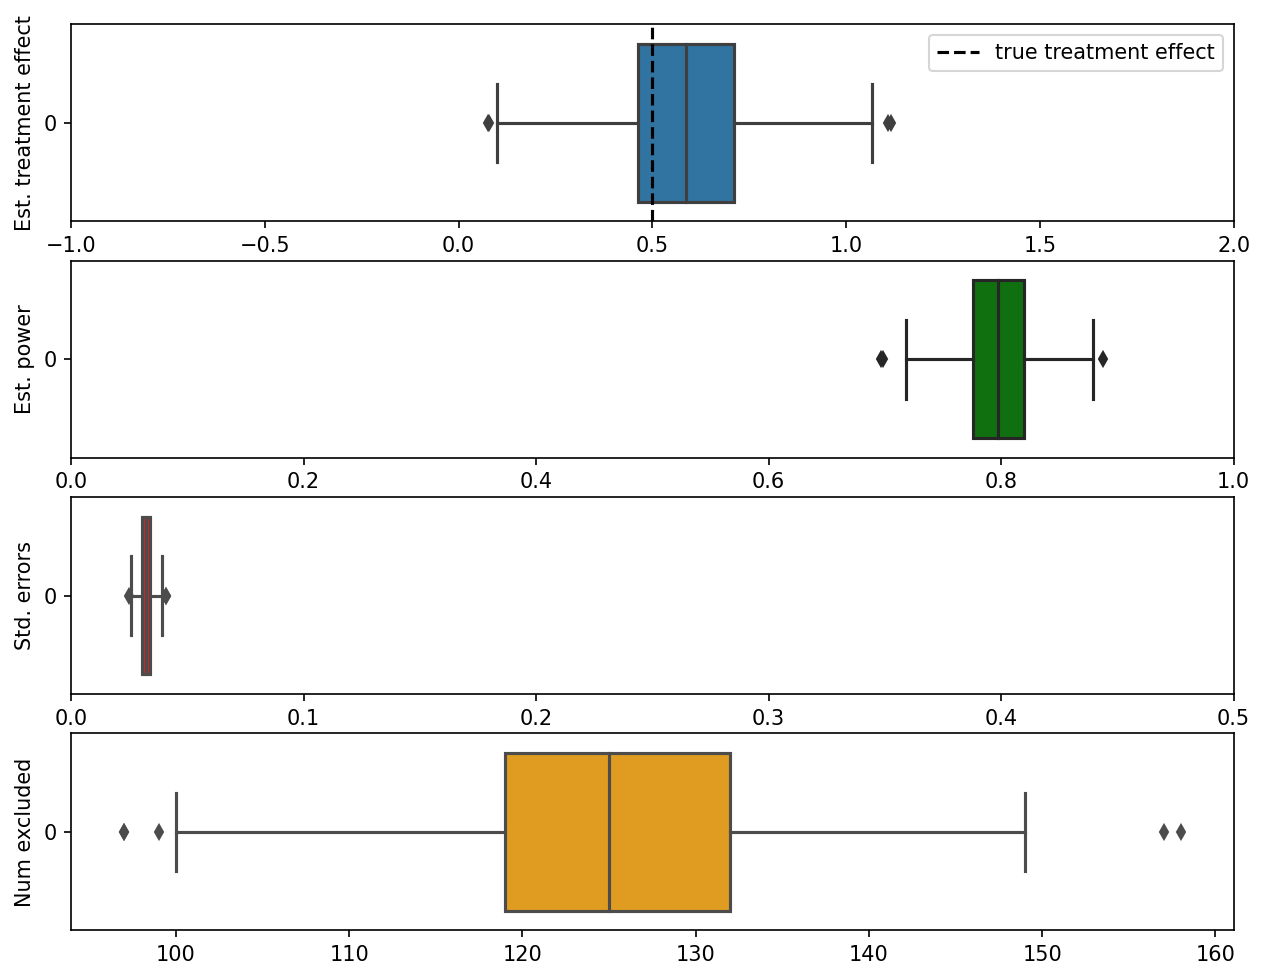

In [36]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "TneqZ")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.36324685405498247
CPU times: user 1min 46s, sys: 3.47 s, total: 1min 50s
Wall time: 13.8 s


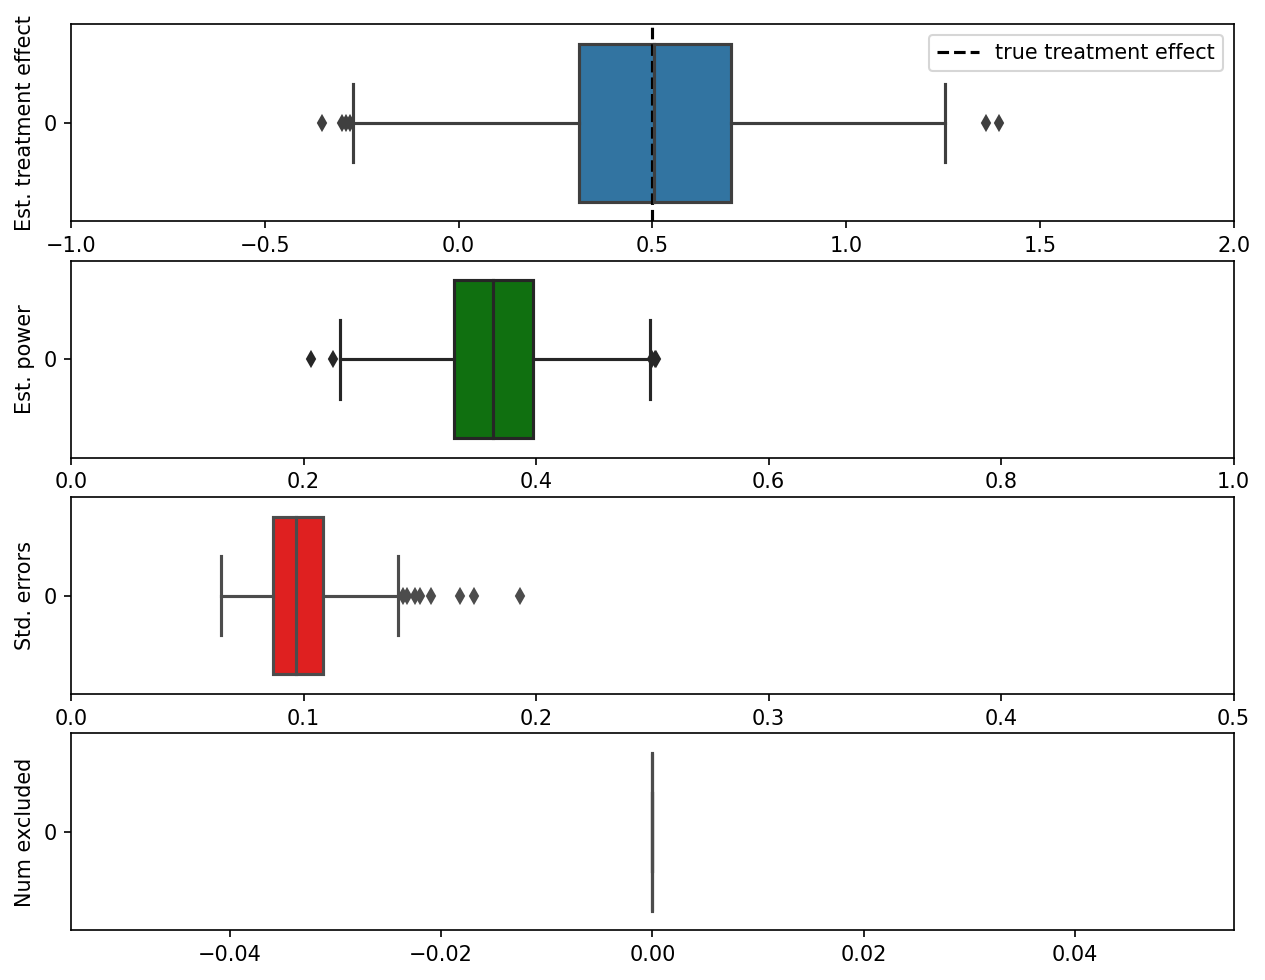

In [37]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, None)

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

## Widget TODO revise

In [415]:
pd.set_option("display.precision", 3)

In [416]:
import warnings
warnings.filterwarnings('ignore')

@interact_manual(
    excl_type = [
        ("No exclusion", None),
        ("Per-protocol: T neq Z", "TneqZ"),
        ("True noncompliers", "comply")
    ],
    n=(100,1000,50),
    n_trials=(100,1000,50),
    prop_comply=(0,1, 0.1),
    tau=(-1, 1, 0.1),
    confound_str=(0, 1, 0.1)
)
def sim_plot_iv_exclusion(excl_type, n=500, n_trials=500, prop_comply=0.5, tau=0.5, confound_str=0.8):
    tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, excl_type, confound_str)
    df = pd.DataFrame()
    df['tau_hat'] = tau_hats
    df['var_hat'] = var_hats
    df['power'] = pwrs
    df['n_exclude'] = n_exclude
    plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
    display(df.describe().transpose())

interactive(children=(Dropdown(description='excl_type', options=(('No exclusion', None), ('Per-protocol: T neq…

**TODO** figure out why excluding the observed noncompliers *isn't* biasing estimates
- answer: "per-protocol" analyses (where we only analyze observed compliers) is generally biased, but only when there are confounders (see Chapter 23.9.2 of Imbens & Rubin)
- Next thing to figure out: why is the power increase minimal even in the presence of a perfect compliance indicator?

# Power graphs as a function of compliance exclusion

- **note**: lifted from `naci_iv_walkthrough.ipynb` from old repo.

## Run simulation

In [65]:
%%time

n_samples = 1000
num_trials = 100
tau = 0.5

n_exclude = np.arange(0,901, 50)

exclude_list = []
complier_pwr_list = []
hat_pwr_list = []
var_list = []
target_effect_list = []
trial_list = []
comply_list = []
tau_list = []

compliances = [0.2, 0.4, 0.6]

formula = 'Y ~ 1+ [T ~ Z]'
for i in range(num_trials):
    print(i)
    for p_compliance in compliances:
        #df = gen_fuzzy_rdd_unif(n_samples, tau, p_compliance, seed=i)
        #df = df.sort_values('p_compliance', ascending=False)
        p_at = (1 - p_compliance) / 2
        p_nt = (1 - p_compliance) / 2
        
        df = generate_IV_comply_indicator(seed=i, 
                                       n_samples=n_samples, 
                                       tau=tau,
                                       prop_at=p_at,
                                       prop_nt=p_nt)
        #df['comply_order'] = df['comply_status'].apply(comply_to_int)
        
        #df = df.sort_values('comply_order', ascending=False)
        df = df.sort_values('X', ascending=False)
        for excl in n_exclude:
            trial_list.append(i)
            exclude_list.append(excl)
            comply_list.append(p_compliance)
            
            sel_df = df.head(int(n_samples-excl))
            ctl = sel_df[sel_df['T'] == 0]
            effect = np.std(ctl['Y']) / 2
            target_effect_list.append(effect)
            
            iv_model = IV2SLS.from_formula(formula, sel_df)
            iv_results = iv_model.fit(cov_type='robust')
            var = iv_results.std_errors['T']**2
            tau_hat = iv_results.params['T']
            var_list.append(var)
            tau_list.append(tau_hat)
            
            pwr = rdd_power(tau, var)
            #pwr = iv_power(sel_df, tau)
            complier_pwr_list.append(pwr)
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/utility.py:208: RuntimeWarning: divide by zero encountered in true_divide
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/utility.py:208: RuntimeWarning: invalid value encountered in matmul
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/iv/model.py:579: RuntimeWarning: invalid value encountered in matmul
  q = vpmzv_sqinv @ (ex1.T @ ex1) @ vpmzv_sqinv


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 11min 11s, sys: 21.1 s, total: 11min 32s
Wall time: 1min 26s


## Plot power curves

In [66]:
pwr_unif_df = pd.DataFrame()
pwr_unif_df['n_exclude'] = exclude_list
pwr_unif_df['trial'] = trial_list
pwr_unif_df['complier_pwr'] = complier_pwr_list
pwr_unif_df['frac_comply'] = comply_list
pwr_unif_df['fraction compliers'] = pwr_unif_df['frac_comply'] 

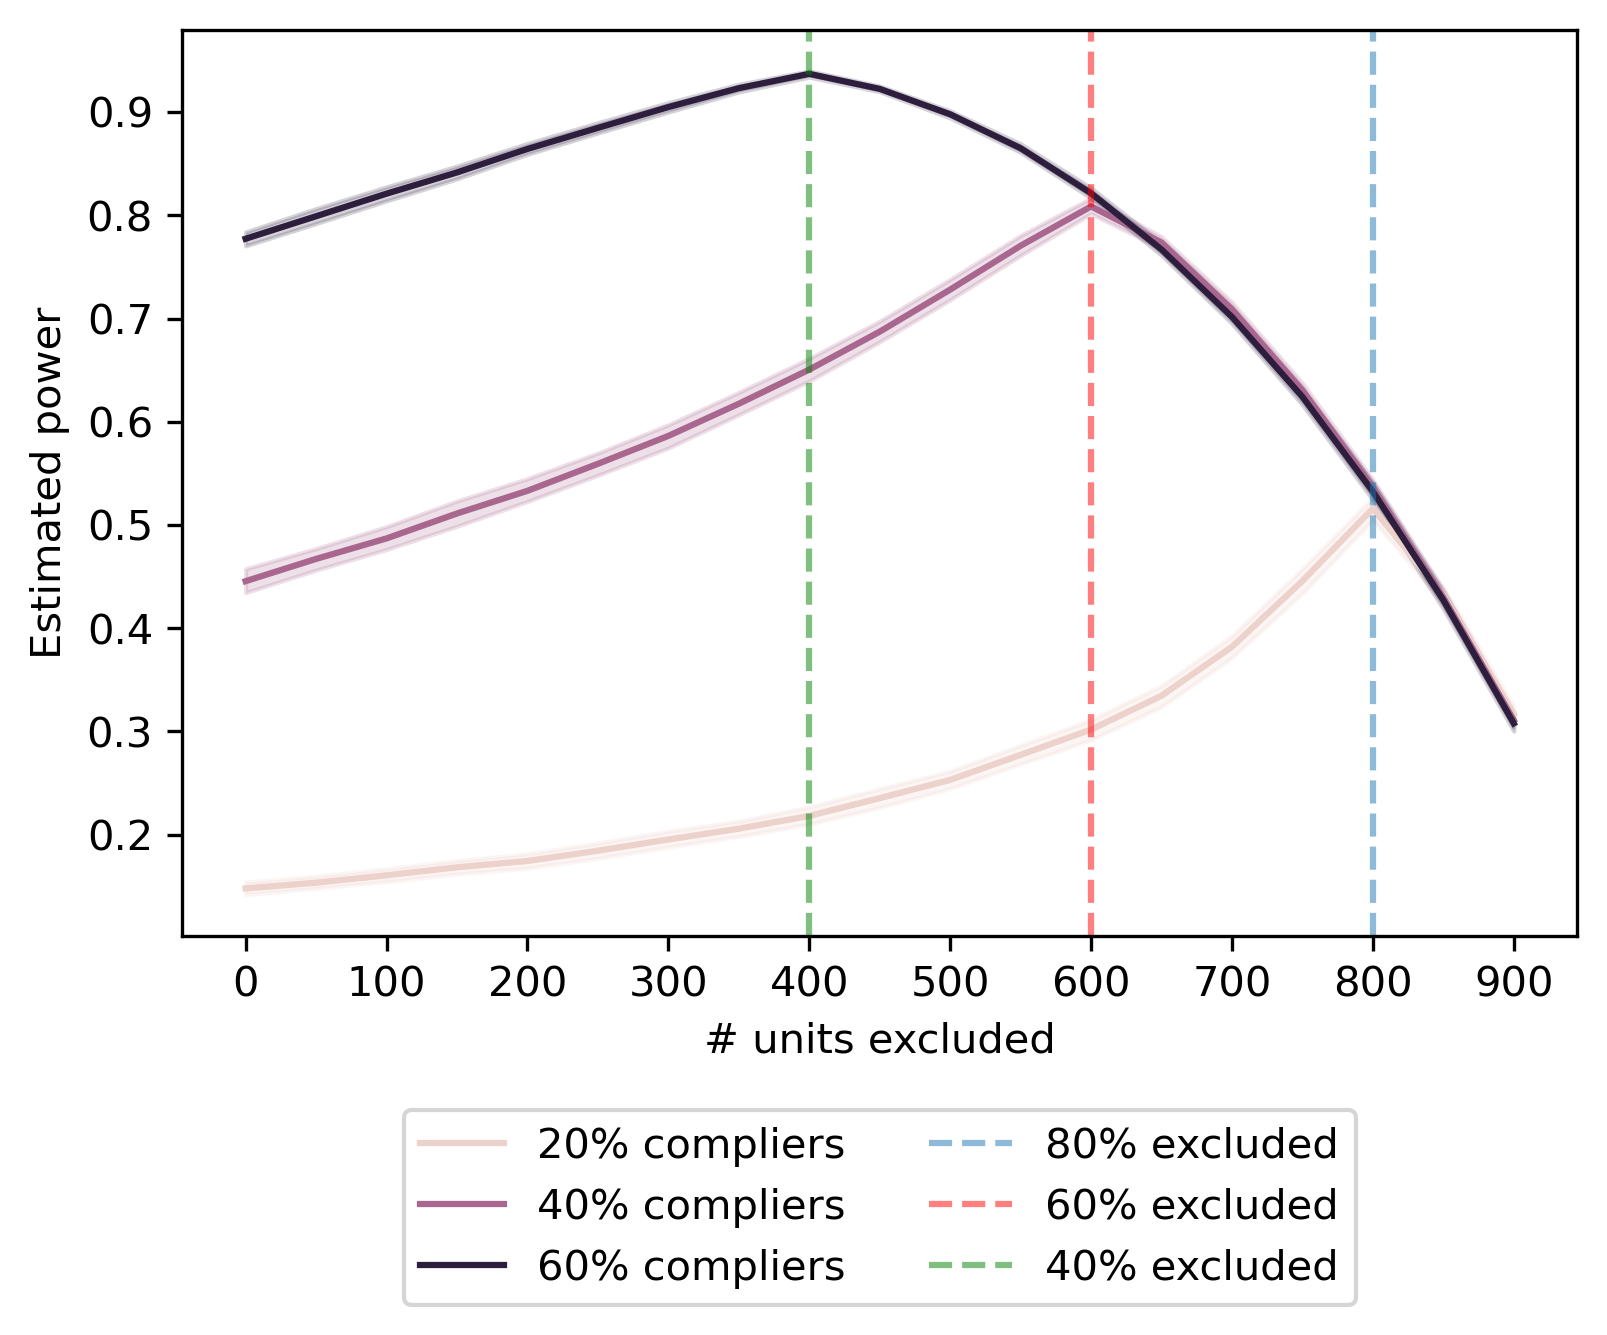

In [68]:
sns.lineplot(x='n_exclude', y='complier_pwr', data=pwr_unif_df, hue='fraction compliers', legend='full')
plt.axvline(x=800, label="80% excluded", ls='--', alpha=0.5)
plt.axvline(x=600, label="60% excluded", ls='--', color="r", alpha=0.5)
plt.axvline(x=400, label="40% excluded", ls='--', color='g', alpha=0.5)

plt.xticks(np.arange(0,1000,100))
legend = plt.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, -0.3))
legend.get_texts()[0].set_text('20% compliers')
legend.get_texts()[1].set_text('40% compliers')
legend.get_texts()[2].set_text('60% compliers')
plt.ylabel("Estimated power")
plt.xlabel("# units excluded")

plt.savefig("../figures/pwr_known_comply.png", bbox_inches='tight')

# ML exploration

## Build simulated data

In [13]:
n = 2000
tau = 0.5
#prop_comply = 0.4
prop_at = 0.4
prop_nt = 0.4
prop_z = 0.8
seed = 42

data = generate_IV_comply_indicator(n_samples=n, 
                                    tau=tau, 
                                    seed=seed, 
                                    C_T=0.8, 
                                    prop_nt=prop_nt, 
                                    prop_at=prop_at, 
                                    prop_z=prop_z)
display(data.head())

,comply_coeff,comply_status,Z,X,T,C,Y,B
0,0.374540,nt,1,0,0,1.498166,-0.027406,0.25
1,0.950714,co,1,1,1,-1.612906,-2.267070,0.00
2,0.731994,at,0,0,1,-1.059541,0.545661,0.25
3,0.598658,at,0,0,1,3.497328,4.511618,0.25
4,0.156019,nt,0,0,0,-0.339402,0.974380,0.25


In [14]:
data['comply_indicator'] = data['T'] == data['Z'] 

## Split data

- **note**: the stratified split is on the "known compliance" indicator, so may be imbalanced for the true target $T$

In [16]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(data, y=data['comply_indicator']):
    indices.append(test_idx)
    

s1_df = data.iloc[indices[0]].copy()
s2_df = data.iloc[indices[1]].copy()


## Linear model of likely compliance

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [17]:
lr_model = LogisticRegression()
lr_model.fit(s1_df[['X']], s1_df['comply_indicator'])
print(lr_model.score(s1_df[['X']], s1_df['comply_indicator']))
print(lr_model.score(s2_df[['X']], s2_df['comply_indicator']))

0.6
0.601


In [18]:
s1_df[s1_df['X'] == 0]['comply_indicator'].value_counts()

False    400
True     395
Name: comply_indicator, dtype: int64

In [19]:
lr_preds = lr_model.predict_proba(s2_df[['X']])[:, 1]

- likely compliance prediction will predict p(likely compliance) == 1 for X=1, then E(likely compliance | X = 0) 

## RPy2 causal forest on heterogeneous instrument effects

In [665]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r

In [666]:
pandas2ri.activate()
r_grf = importr('grf')
r_utils = importr('utils')

In [667]:
r_forest = r_grf.causal_forest(
    # grf expects a matrix for X, vectors for W, Y
    X = s1_df[['X']],
    W = s1_df['Z'],
    Y = s1_df['T'],
)

In [668]:
# predicted heterogeneous instrument effects
comp_hat = r.predict(r_forest, s2_df[['X']])

In [669]:
comp_hat.columns = ['cf_preds']
comp_hat['lr_preds'] = lr_preds

In [670]:
comp_hat

,cf_preds,lr_preds
1,1.000,0.988
2,1.000,0.988
3,1.000,0.988
4,-0.031,0.358
5,-0.031,0.358
...,...,...
996,1.000,0.988
997,1.000,0.988
998,-0.031,0.358
999,-0.031,0.358


## Back of the envelope checking of closed form solution for likely compliance

- p_nt = 0.12
- p_at = 0.48
- p_co = 0.4

In [671]:
data[(data['Z'] == 0) & (data['X'] == 0)]['T'].mean()

0.19393939393939394

In [672]:
data[(data['Z'] == 1) & (data['X'] == 0)]['T'].mean()

0.19696969696969696

In [673]:
test = data[data['X'] == 0]
test = test[test['Z'] == 1]
(test['Z'] == test['T']).sum()

169

In [674]:
p_at = data[(data['Z'] == 0) & (data['T'] == 1)].shape[0] / data[data['Z'] == 0].shape[0]
p_at

0.11130434782608696

In [676]:
p_nt = data[(data['Z'] == 1) & (data['T'] == 0)].shape[0] / data[data['Z'] == 1].shape[0]
p_nt

0.48350877192982455

In [677]:
1 - p_at - p_nt

0.40518688024408844

In [678]:
data[data['X'] == 1]['T'].mean()

0.6982758620689655

In [679]:
test = data[data['X'] == 1]

(test['Z'] == 1).sum()

567

In [682]:
(p_nt + prop_z*(p_at - p_nt)) / (p_nt + p_at)

0.31227494229289554

In [683]:
nt = .48
at = 0.12
co = 1 - nt - at
p = prop_z
(nt + p*(at - nt)) / (1 - co)

0.32

## EconML causal forest on heterogeneous instrument effects

In [24]:
# default params
cforest = CausalForestDML()

cforest.fit(Y=s1_df['T'],
            T=s1_df['Z'],
            X=s1_df['X'].values.reshape(-1,1))

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [26]:
# predicted heterogeneous instrument effects
comp_hat = cforest.effect(s2_df[['X']])

In [28]:
comp_df = pd.DataFrame()

comp_df['cf_preds'] = comp_hat
comp_df['lr_preds'] = lr_preds

In [30]:
comp_df.head(20)

,cf_preds,lr_preds
0,-0.022841,0.501797
1,1.000057,0.980838
2,-0.022841,0.501797
3,-0.022841,0.501797
4,-0.022841,0.501797
5,1.000057,0.980838
6,-0.022841,0.501797
7,-0.022841,0.501797
8,-0.022841,0.501797
9,1.000057,0.980838


# Compliance prediction with covariates and causal forests

# Sandbox/reference

In [ ]:
iv_model = IV2SLS.from_formula(formula, sel_df)
iv_results = iv_model.fit(cov_type='robust')
var = iv_results.std_errors['T']**2
tau_hat = iv_results.params['T']
var_list.append(var)
tau_list.append(tau_hat)

pwr = rdd_power(tau, var)
#pwr = iv_power(sel_df, tau)
complier_pwr_list.append(pwr)

In [655]:
# # alternative formulation with shared covariance
# def generate_IV(n, tau, prop_comply, seed, C_T=0.8, prop_nt=0.5, prop_z=0.5):
#     """
#     Generates IV data with compliance indicator X.
    
#     Args:
#         prop_comply (float): the *total proportion* of compliers in the data
#         C_T (float): the confounding strength between C and T
#             TODO needs to be fixed, by generating shared covariance for compliers and noncompliers
#         prop_nt (float): the proportion of never takers *among non-compliers*
        
    
#     """
#     np.random.seed(seed)

#     Z_T = 0.8

#     # vars:             Z    T    C
#     covar = np.array([[1.0, Z_T, 0.0], # Z
#                       [Z_T, 1.0, C_T], # T
#                       [0.0, C_T, 1.0]])# C
    
#     covar += np.eye(3,3)

#     # vars:  Z  T  C
#     means = [0, 0, 0]

#     # generate some data
#     data = np.random.multivariate_normal(mean=means, cov=covar, size=n)

#     # generate binary instrument
#     Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)

#     # generate random binary covariate for compliance
#     X = np.random.random_sample(n)
#     X = (X < prop_comply).astype(int)

#     # generate endogenous treatment
#     T = (data[:, 1] > 0).astype(int)

#     # fill in Z when the sample is a complier
#     T = np.where(X == 1, Z, T)
    
#     # set never takers to prop_nt of non-compliers
#     T[X != 1] = (np.random.sample((X != 1).sum()) > prop_nt).astype(int)

#     # generate a confounder: correlation with treatment
#     # problem with this approach, creates a path T -> C -> Y
#     #     C = np.random.normal(loc=C_T * (T - np.mean(T)), 
#     #                          scale=1 - (C_T**2))
#     C = data[:, 2]
    
#     # add noncomplier bias
#     nc_bias_eff = 0.25
#     B = np.where(X != 1, nc_bias_eff, 0)

#     Y = (tau + B)*T + C + np.random.normal(0, 1, n)
    
#     df = pd.DataFrame()
#     df['Z'] = Z
#     df['X'] = X
#     df['T'] = T
#     df['C'] = C
#     df['Y'] = Y
#     df['B'] = B
    
#     return df